# [DonorsChoose.org Application Screening](https://www.kaggle.com/c/donorschoose-application-screening)

**Objective:** To find out which project is more likely to get selected.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
import xgboost as xgb
import pandas_profiling as pp
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gvvj9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Overview

In [2]:
train = pd.read_csv(r'D:\kaggle\DonorsChoose\train.csv', parse_dates=['project_submitted_datetime'])
test = pd.read_csv(r'D:\kaggle\DonorsChoose\test.csv', parse_dates=['project_submitted_datetime'])
resources = pd.read_csv(r'D:\kaggle\DonorsChoose\resources.csv')
submission = pd.read_csv(r'D:\kaggle\DonorsChoose\sample_submission.csv')

In [3]:
train.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [4]:
resources.head()

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


pandas_profiling library can generate a report, which gives a fast analysis of all features and shows their statistics.

In [5]:
pp.ProfileReport(resources[['quantity', 'price']])

Number of variables,2
Number of observations,1541272
Total Missing (%),0.0%
Total size in memory,23.5 MiB
Average record size in memory,16.0 B
Numeric,2
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [6]:
pp.ProfileReport(train[['teacher_id', 'teacher_prefix', 'school_state', 
                        'project_grade_category', 'teacher_number_of_previously_posted_projects', 
                        'project_is_approved']])

Number of variables,6
Number of observations,182080
Total Missing (%),0.0%
Total size in memory,8.3 MiB
Average record size in memory,48.0 B
Numeric,1
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null datetime64[ns]
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                

We can see several things from this overview:

* There is a variety of features: numerical, categorical, text and date.
* Only teacher prefix column has missing values.
* project_essay_3 and project_essay_4 columns also have missing values, but this is a special case, we will talk about it later.
* Some texts have '\n' and '\r' symbols, so they'll need to be cleaned.
* Several categorical features have a lot of unique values.
* Some teachers have submitted more than 70 projects.

### Feature Analysis

We saw a lot of information about features, so let's now analyze each of them in more details.

#### 1. Essays

Starting on May 17, 2016, the number of essays was reduced from 4 to 2. Essentially old 1 and 2 became new 1 and old 3 and 4 became new 2. This means that columns 'project_essay_3' and 'project_essay_4' have NaN values since that date. Let's see the number of projects before and after this date.

In [8]:
print('Projests before 2016-05-17:', np.sum(train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7)))
print('Projests after 2016-05-17:', np.sum(train.project_submitted_datetime.dt.date >= datetime.date(2016, 5, 7)))

Projests before 2016-05-17: 3751
Projests after 2016-05-17: 178329


So only 3751 (or 2%) of all projects were submitted before this date. We have several options here: split dataset into two parts and train different models on them, drop samples before this date, combine 1 with 2 and 3 with 4 for old samples or do nothing. I prefer combining old samples.

In [9]:
train.loc[train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_1'] = \
train.loc[train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_1'] + ' ' +\
train.loc[train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_2']

train.loc[train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_2'] = \
train.loc[train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_3'] + ' ' +\
train.loc[train.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_4']

train.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

Let's clean and visualize information in these columns.

In [10]:
# replacing symbols which appeared due to formatting
train['project_essay_1'] = train['project_essay_1'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
train['project_essay_2'] = train['project_essay_2'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))

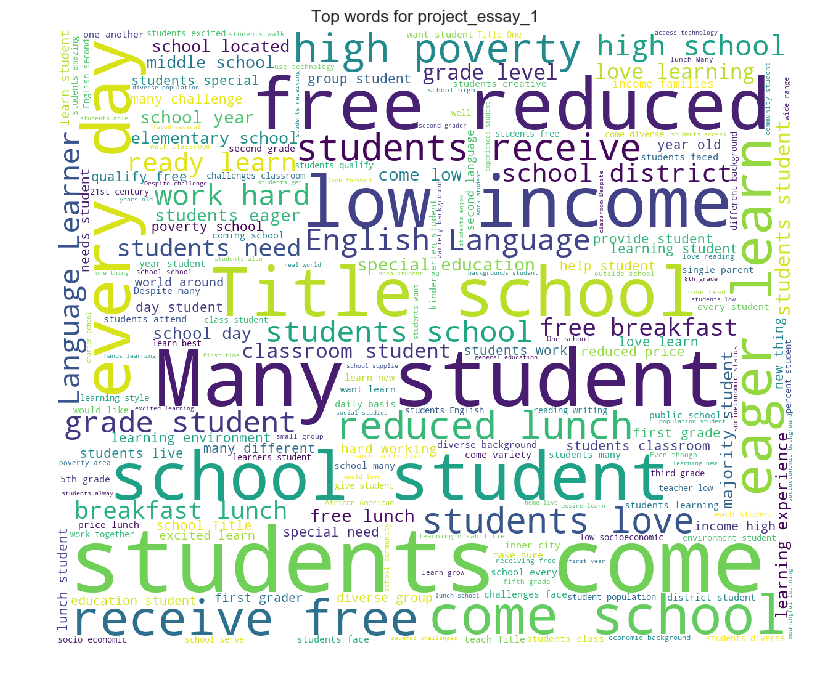

In [11]:
text = ' '.join(train['project_essay_1'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words for project_essay_1')
plt.axis("off")
plt.show()

It isn't surprising that this essay is about students, how they learn and want continue learning as well as about some problems which the schools face.

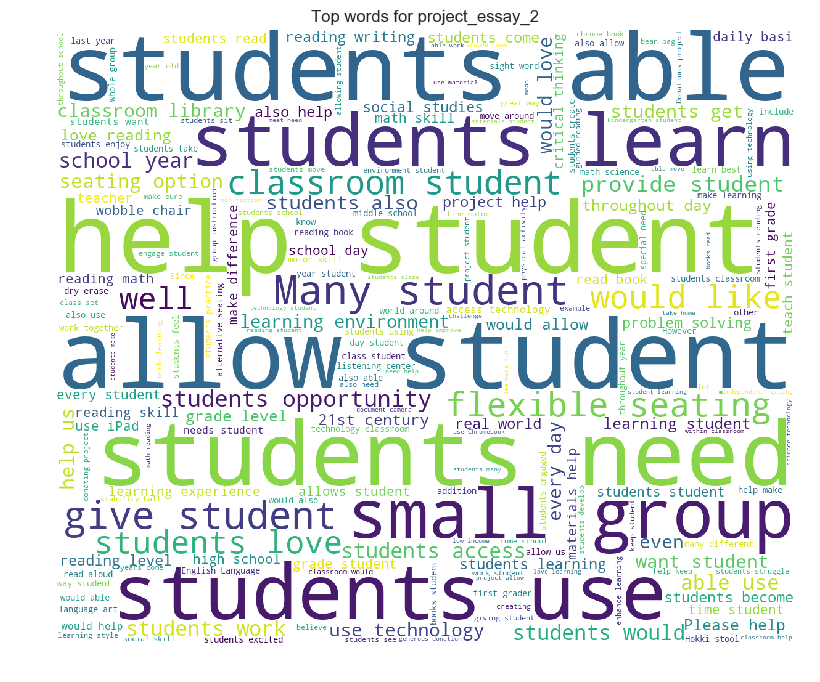

In [12]:
text = ' '.join(train['project_essay_2'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words for project_essay_2')
plt.axis("off")
plt.show()

Second essay is more about problems which students face, things which will help them and how exactly will they help.

#### 2. project_resource_summary

In [13]:
train.project_resource_summary[train.project_resource_summary.str.contains('My students need') == False].values

array(['I need a dash cam to protect myself and students in case of an accident and to also use as a teaching tool in the classroom.',
       'I need smaller tables for guided reading groups.'], dtype=object)

It is quite interesting that there are 2 projects where teachers don't use phrase "My students need" and still both of them are for students.

In [14]:
train['project_resource_summary'] = train['project_resource_summary'].\
apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))

Let's see what words are used in summaries of approved and non-approved projects

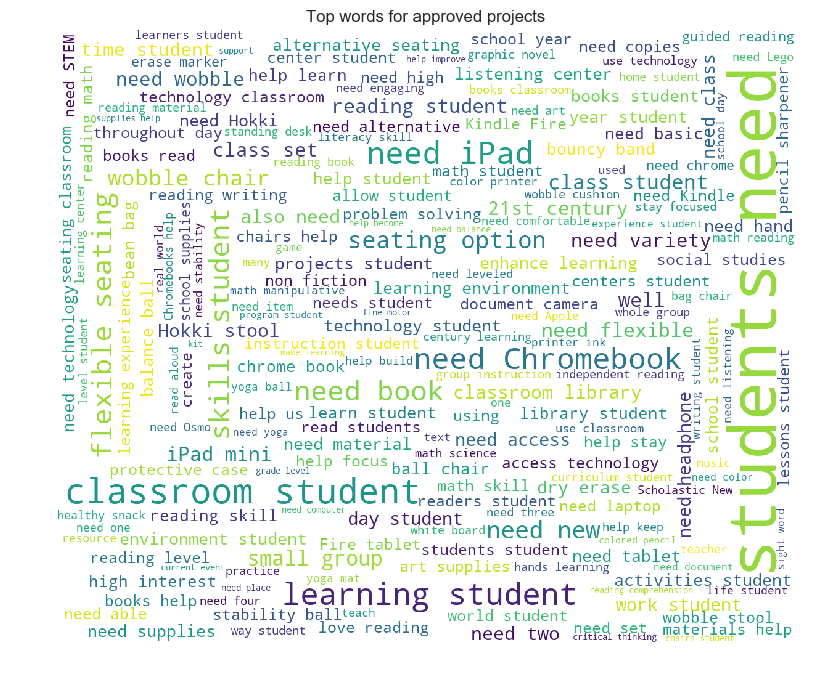

In [15]:
text = ' '.join(train.loc[train['project_is_approved'] == 1, 'project_resource_summary'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words for approved projects')
plt.axis("off")
plt.show()

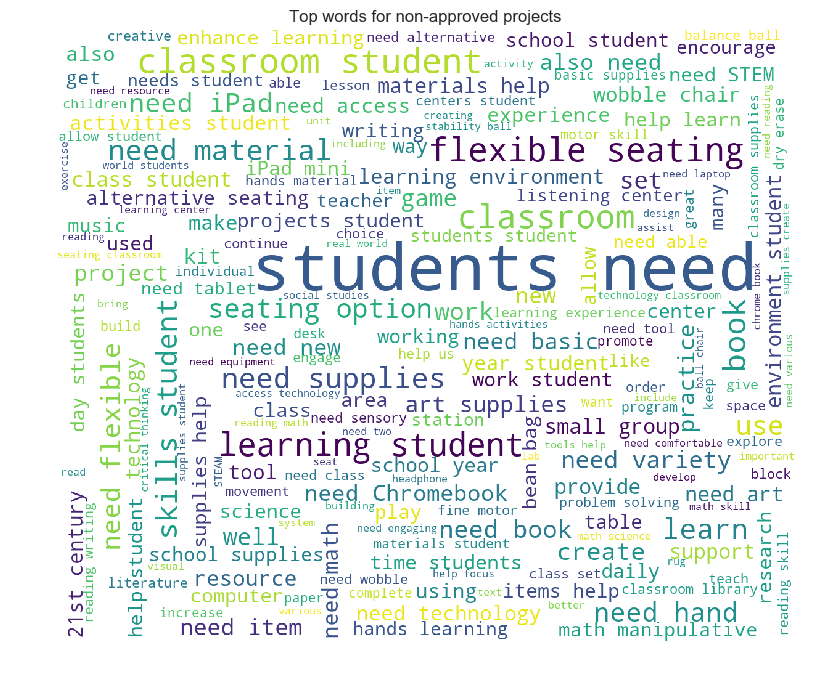

In [16]:
text = ' '.join(train.loc[train['project_is_approved'] == 0, 'project_resource_summary'].values)
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words for non-approved projects')
plt.axis("off")
plt.show()

I'd say that there is no real difference.

#### 3. project_title

Let's see what project titles are about.

In [17]:
train['project_title'] = train['project_title'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
text = ' '.join(train['project_title'].values)
text = [i for i in ngrams(text.split(), 3)]
print('Common trigrams.')
Counter(text).most_common(20)

Common trigrams.


[(('Flexible', 'Seating', 'for'), 1184),
 (('in', 'the', 'Classroom'), 665),
 (('Wiggle', 'While', 'We'), 452),
 (('Our', 'Way', 'to'), 393),
 (('Wiggle', 'While', 'You'), 384),
 (('Like', 'to', 'Move'), 362),
 (('We', 'Like', 'to'), 356),
 (('Move', 'It,', 'Move'), 354),
 (('Read', 'All', 'About'), 331),
 (('Can', 'You', 'Hear'), 321),
 (('Technology', 'in', 'the'), 320),
 (('While', 'We', 'Work'), 294),
 (('the', '21st', 'Century'), 289),
 (('While', 'We', 'Work!'), 274),
 (('to', 'Move', 'It,'), 267),
 (('All', 'About', 'It!'), 264),
 (('Flexible', 'Seating', 'in'), 257),
 (('While', 'You', 'Work'), 252),
 (('the', 'Love', 'of'), 236),
 (('at', 'a', 'Time'), 231)]

In [18]:
print('Common titles.')
train['project_title'].value_counts().head(20)

Common titles.


Flexible Seating                377
Wiggle While You Work           150
Wiggle While We Work            149
Can You Hear Me Now?            144
Wiggle While You Work!          135
Wiggle While We Work!           123
We Like to Move It, Move It!    101
Listen Up!                       83
Technology in the Classroom      79
Full STEAM Ahead!                74
Alternative Seating              71
Let's Get Moving!                68
Classroom Supplies               67
Classroom Library                56
Let's Get Organized!             51
Supplies for Success             50
Flexible Seating!                50
Wobble While We Work!            49
Wobble While You Work            49
Read All About It!               46
Name: project_title, dtype: int64

Teachers usually write about things which they need or make some exclamations. Let's see summaries of projects with interesting titles!

In [19]:
print('Title:', 'Wiggle While You Work')
for i in train.loc[train['project_title'] == "Wiggle While You Work", 'project_resource_summary'].values[:3]:
    print(i)
print()
print('Title:', 'Can You Hear Me Now?')
for i in train.loc[train['project_title'] == "Can You Hear Me Now?", 'project_resource_summary'].values[:3]:
    print(i)
print()
print('Title:', 'We Like to Move It, Move It!')
for i in train.loc[train['project_title'] == "We Like to Move It, Move It!", 'project_resource_summary'].values[:3]:
    print(i)
print()
print('Title:', 'Listen Up!')
for i in train.loc[train['project_title'] == "Listen Up!", 'project_resource_summary'].values[:3]:
    print(i)
print()
print('Title:', "Let's Get Moving!")
for i in train.loc[train['project_title'] == "Let's Get Moving!", 'project_resource_summary'].values[:3]:
    print(i)
print()
print('Title:', 'Read All About It!')
for i in train.loc[train['project_title'] == "Read All About It!", 'project_resource_summary'].values[:3]:
    print(i)
print()

Title: Wiggle While You Work
My students need seating options that offer choice beyond traditional desks.
My students need 10 Wobble Chairs to help them wiggle while working.
My students need these exercise balls as an outlet during small group instruction. From my experience students learn in a variety of ways.

Title: Can You Hear Me Now?
My students need headphones to use with our lap tops. We are so fortunate to have access to lap tops to use in the classroom. However, Kindergarten classrooms are noisy places!
My students need multipurpose headphones to use during reading and math centers.
My students need access to headphones to fully utilize our new web-based intervention program.

Title: We Like to Move It, Move It!
My students need adapted PE equipment such as a parachute and slow motion balls!
My students need the Activity Scarves, the Sight-Word Steps, and the Healthy CD library to help them move in the classroom.
My students need the opportunity to have flexible seating to b

#### 4. teacher_prefix

In [20]:
train.teacher_prefix.value_counts(dropna=False)

Mrs.       95405
Ms.        65066
Mr.        17667
Teacher     3912
Dr.           26
NaN            4
Name: teacher_prefix, dtype: int64

In [21]:
pd.crosstab(train.teacher_prefix, train.project_is_approved, dropna=False, normalize='index')

project_is_approved,0,1
teacher_prefix,,
Dr.,0.192308,0.807692
Mr.,0.157978,0.842022
Mrs.,0.145915,0.854085
Ms.,0.156948,0.843052
Teacher,0.205777,0.794223


We can see that there are much more female teachers than male, which is normal. And it seems that project approval rate is independent from teacher gender. If anything writing title could lead to lesser chances.

In [22]:
#Let's fill missing values with most common one.
train['teacher_prefix'].fillna('Mrs.', inplace=True)

#### 5. school_state

In [23]:
train.groupby('school_state').agg({'project_is_approved': ['mean', 'count']}).\
reset_index().sort_values([('project_is_approved', 'mean')], ascending=False).reset_index(drop=True)

school_state project_is_approved       
                               mean  count
0            DE            0.891341    589
1            WY            0.875706    177
2            OH            0.871467   4139
3            CT            0.871294   2766
4            WA            0.868050   3903
5            WV            0.867700    839
6            NH            0.867121    587
7            ND            0.866935    248
8            SC            0.864923   6463
9            SD            0.862348    494
10           MA            0.860138   4054
11           ME            0.858525    827
12           KY            0.857735   2172
13           MO            0.857547   4247
14           MN            0.857421   2055
15           NV            0.856770   2297
16           CA            0.856431  25695
17           OR            0.855592   2119
18           VA            0.855194   3446
19           IL            0.853792   7332
20           NY            0.853582  12157
21           NC            0.853480   8463
22           KS            0.852830   1060
23           PA            0.852543   5093
24           NE            0.851927    493
25           TN            0.851904   2836
26           AK            0.849192    557
27           VT            0.848921    139
28           AL            0.848393   2955
29           IN            0.847937   4314
30           IA            0.846154   1079
31           CO            0.845787   1887
32           WI            0.845122   2983
33           MI            0.844478   5324
34           RI            0.844211    475
35           HI            0.843498    869
36           MS            0.843384   2222
37           NJ            0.843367   3671
38           ID            0.841869   1113
39           AZ            0.841727   3614
40           MD            0.836290   2480
41           UT            0.835110   2814
42           OK            0.834422   3829
43           GA            0.834087   6636
44           LA            0.834009   3946
45           AR            0.832100   1757
46           MT            0.828125    384
47           FL            0.824500  10359
48           NM            0.822052    916
49           TX            0.815670  12304
50           DC            0.812639    902

As we can see states have a similar approval rate ranging from 0.81 to 0.89. And this rate doesn't depend on the number of projects.

#### 6. project_submitted_datetime

At first let's create new features based on project_submitted_datetime: date, weekday and day of month.

In [24]:
train['date'] = train.project_submitted_datetime.dt.date
train['weekday'] = train.project_submitted_datetime.dt.weekday
train['day'] = train.project_submitted_datetime.dt.day
count_by_date = train.groupby('date')['project_is_approved'].count()
mean_by_date = train.groupby('date')['project_is_approved'].mean()

It could be interesting to see trends:

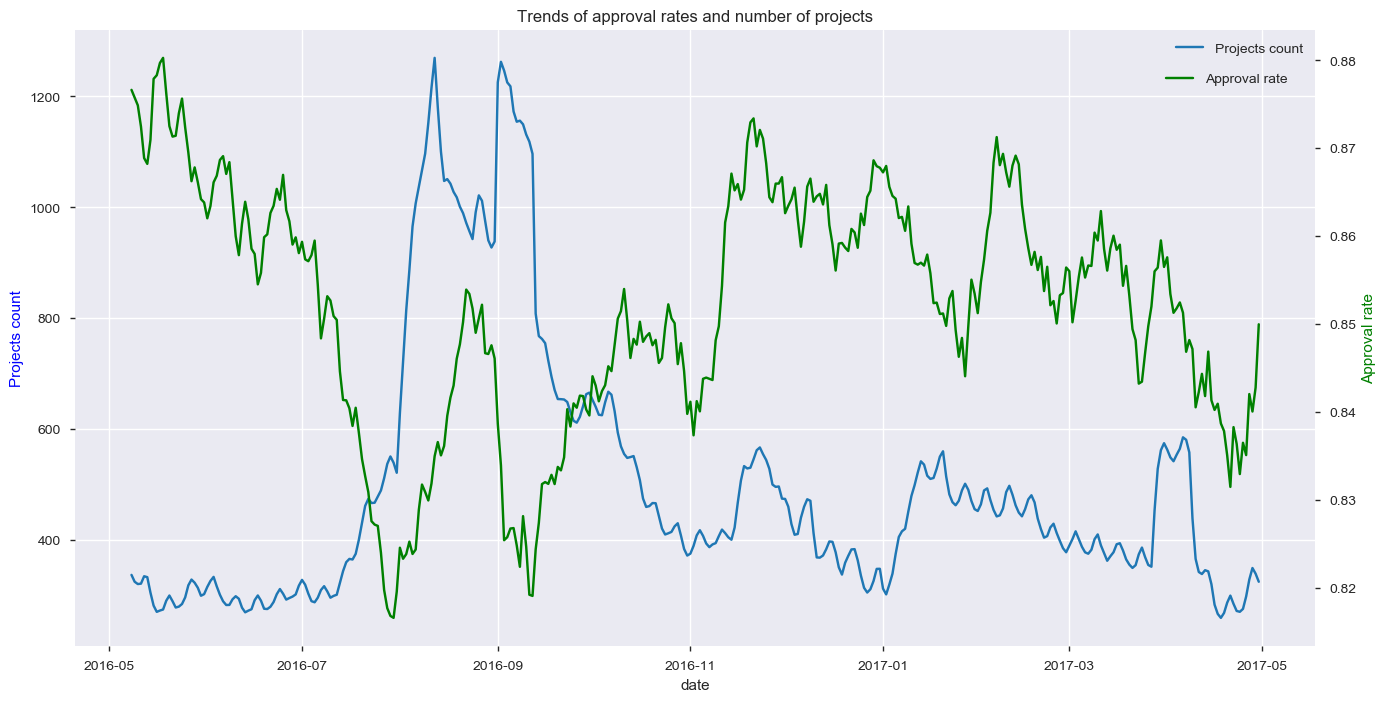

In [25]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of approval rates and number of projects")
count_by_date.rolling(window=12,center=False).mean().plot(ax=ax1, legend=False)
ax1.set_ylabel('Projects count', color='b')
plt.legend(['Projects count'])
ax2 = ax1.twinx()
mean_by_date.rolling(window=12,center=False).mean().plot(ax=ax2, color='g', legend=False)
ax2.set_ylabel('Approval rate', color='g')
plt.legend(['Approval rate'], loc=(0.875, 0.9))
plt.grid(False)

As we can see, we don't have even one year of data, so it is diffucult to make good conclusions about long-term trends, but let's try to make some observations:

* At the very beginning, when teachers had to write 4 essays, the number of projects was quite low, but the approval rate was the highest.
* Then approval rate began rapidly declining. Maybe teachers weren't able to adapt to new rules fast enough, and as a result they weren't able to meet new criteria?
* There are two huge spikes in the number of submitted projects: at the beginning of August and September. I suppose that teachers requested new supplies for the beginning of new school year.
* And in 2017 we can see a downtrend both in the number of submitted projects and approval rates.

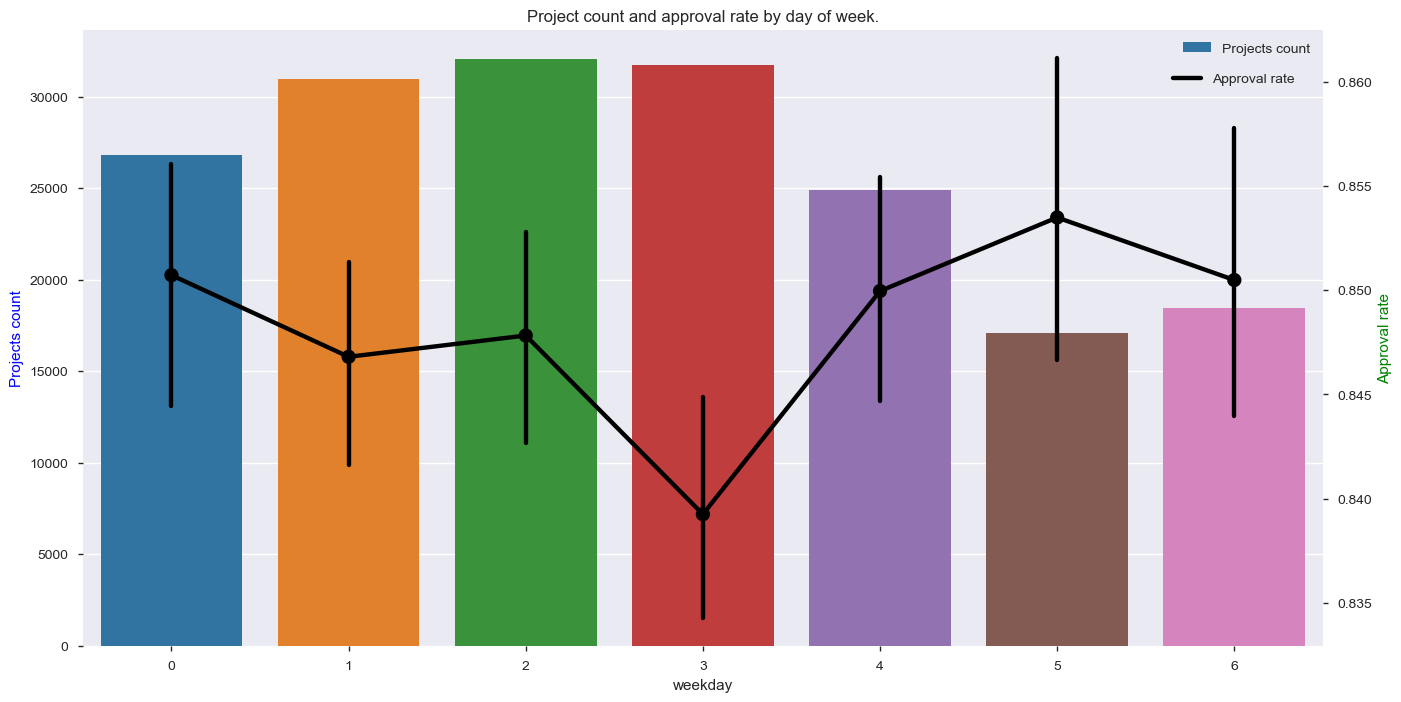

In [26]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Project count and approval rate by day of week.")
sns.countplot(x='weekday', data=train, ax=ax1)
ax1.set_ylabel('Projects count', color='b')
plt.legend(['Projects count'])
ax2 = ax1.twinx()
sns.pointplot(x="weekday", y="project_is_approved", data=train, ci=99, ax=ax2, color='black')
ax2.set_ylabel('Approval rate', color='g')
plt.legend(['Approval rate'], loc=(0.875, 0.9))
plt.grid(False)

We can see that number of submissions is the highest on Wednesday and then lowers on weekends.

#### 7. project_grade_category

In [27]:
pd.crosstab(train.project_grade_category, train.project_is_approved, dropna=False, normalize='index')

project_is_approved,0,1
project_grade_category,,
Grades 3-5,0.146023,0.853977
Grades 6-8,0.156541,0.843459
Grades 9-12,0.164764,0.835236
Grades PreK-2,0.152876,0.847124


It seems that project approval is independent from project grade category.

#### 8. project_subject_categories and project_subject_subcategories

Project categories and subcategories often have several subjects divided by ",". Let's see the number of real subjects.

In [28]:
psc = [i.split(', ') for i in train.project_subject_categories.values]
psc = [i for j in psc for i in j]
print('Common subject categories.')
Counter(psc).most_common()

Common subject categories.


[('Literacy & Language', 86988),
 ('Math & Science', 69248),
 ('Health & Sports', 23712),
 ('Special Needs', 22881),
 ('Applied Learning', 20303),
 ('Music & The Arts', 17054),
 ('History & Civics', 9726),
 ('Warmth', 2327),
 ('Care & Hunger', 2327)]

In [29]:
pss = [i.split(', ') for i in train.project_subject_subcategories.values]
pss = [i for j in pss for i in j]
print('Common subject subcategories.')
Counter(pss).most_common()

Common subject subcategories.


[('Literacy', 56066),
 ('Mathematics', 46884),
 ('Literature & Writing', 36974),
 ('Special Needs', 22881),
 ('Applied Sciences', 17966),
 ('Health & Wellness', 17099),
 ('Visual Arts', 10399),
 ('Environmental Science', 9436),
 ('Gym & Fitness', 7592),
 ('Health & Life Science', 7175),
 ('ESL', 7162),
 ('Early Development', 7149),
 ('History & Geography', 5258),
 ('Music', 5172),
 ('College & Career Prep', 4291),
 ('Other', 3948),
 ('Team Sports', 3643),
 ('Character Education', 3519),
 ('Performing Arts', 3223),
 ('Social Sciences', 3149),
 ('Warmth', 2327),
 ('Care & Hunger', 2327),
 ('Nutrition Education', 2236),
 ('Foreign Languages', 1496),
 ('Extracurricular', 1332),
 ('Civics & Government', 1294),
 ('Parent Involvement', 1103),
 ('Financial Literacy', 956),
 ('Community Service', 712),
 ('Economics', 431)]

#### 9. teacher_number_of_previously_posted_projects

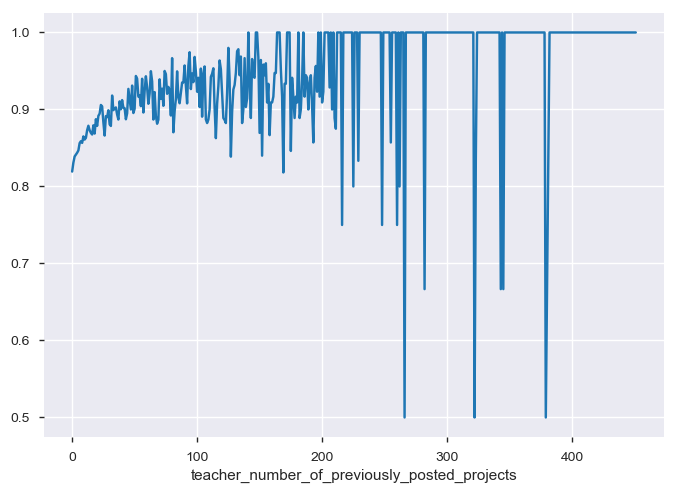

In [30]:
train.groupby('teacher_number_of_previously_posted_projects')['project_is_approved'].mean().plot()

We can see that the more projects were submitted by a techer, the higher are chances for approval.

### Resources

Let's transform the data:

* create cost column which will show total cost of the item (quantity * price).
* group data by project id and show aggregate values.

In [31]:
resources['cost'] = resources['quantity'] * resources['price']
resources_aggregated = resources.groupby('id').agg({'description': ['nunique'], 'quantity': ['sum'], 'cost': ['sum']})
resources_aggregated.columns = ['unique_items', 'total_quantity', 'total_cost']
resources_aggregated.reset_index(inplace=True)
resources_aggregated['mean_cost']=resources_aggregated['total_cost']/resources_aggregated['total_quantity']
resources_aggregated.head()

,id,unique_items,total_quantity,total_cost,mean_cost
0,p000001,4,7,833.63,119.090000
1,p000002,14,21,630.28,30.013333
2,p000003,4,4,298.97,74.742500
3,p000004,93,98,1126.22,11.492041
4,p000005,2,8,702.31,87.788750


99 percentile is 999.99.


Text(0.5,1,'transformed')

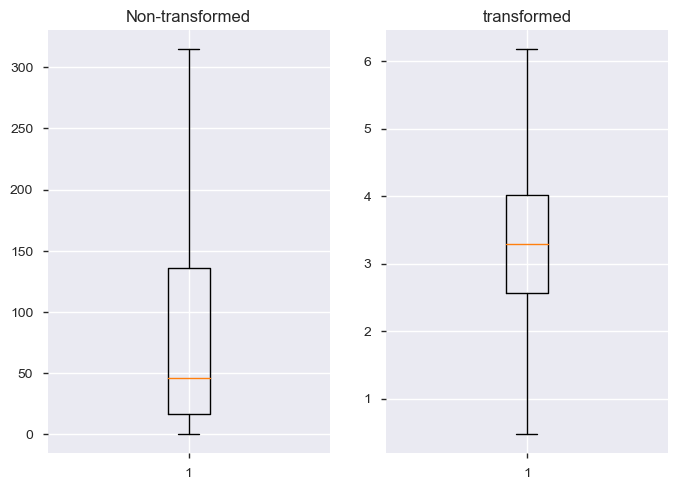

In [32]:
#We can see that prices are heavily skewed. Let's try using boxcox transformation.
print('99 percentile is {0}.'.format(np.percentile(resources_aggregated.mean_cost, 99)))
plt.subplot(1,2,1)
plt.boxplot(resources_aggregated.mean_cost,showfliers=False);
plt.title('Non-transformed')
resources_aggregated['mean_cost'] = stats.boxcox(resources_aggregated.mean_cost + 1)[0]
plt.subplot(1,2,2)
plt.boxplot(resources_aggregated.mean_cost,showfliers=False);
plt.title('transformed')

As we can see boxcox transformation is very useful in such cases. Let's try to do the same for other columns.

Text(0.5,1,'transformed')

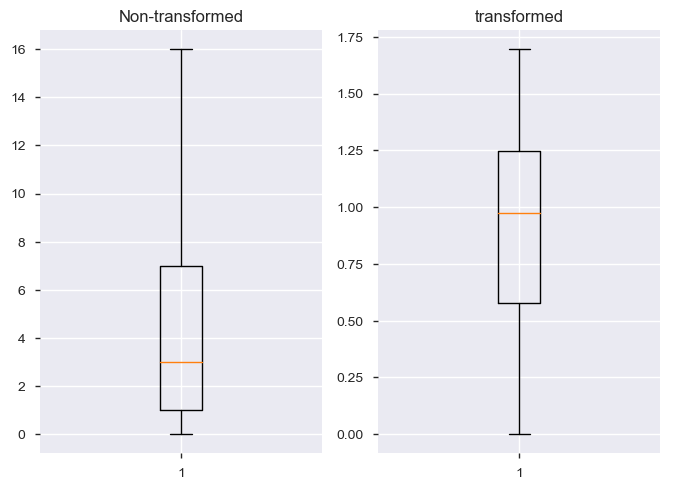

In [33]:
plt.subplot(1,2,1)
plt.boxplot(resources_aggregated.unique_items,showfliers=False);
plt.title('Non-transformed')
resources_aggregated['unique_items'] = stats.boxcox(resources_aggregated.unique_items + 1)[0]
plt.subplot(1,2,2)
plt.boxplot(resources_aggregated.unique_items,showfliers=False);
plt.title('transformed')

Text(0.5,1,'transformed')

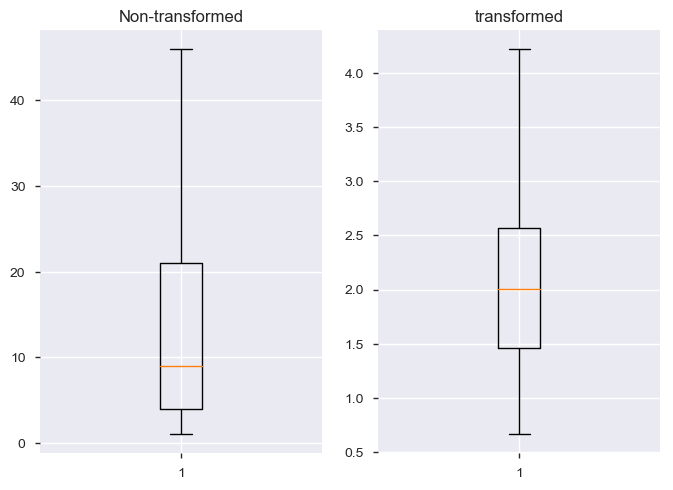

In [34]:
plt.subplot(1,2,1)
plt.boxplot(resources_aggregated.total_quantity,showfliers=False);
plt.title('Non-transformed')
resources_aggregated['total_quantity'] = stats.boxcox(resources_aggregated.total_quantity + 1)[0]
plt.subplot(1,2,2)
plt.boxplot(resources_aggregated.total_quantity,showfliers=False);
plt.title('transformed')

Text(0.5,1,'transformed')

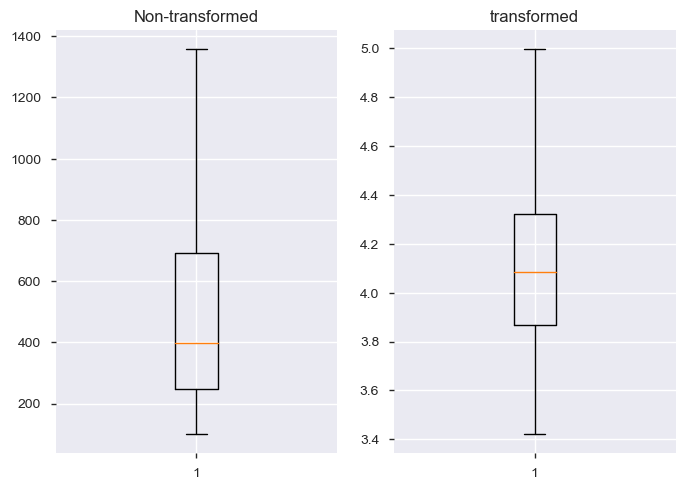

In [35]:
plt.subplot(1,2,1)
plt.boxplot(resources_aggregated.total_cost,showfliers=False);
plt.title('Non-transformed')
resources_aggregated['total_cost'] = stats.boxcox(resources_aggregated.total_cost + 1)[0]
plt.subplot(1,2,2)
plt.boxplot(resources_aggregated.total_cost,showfliers=False);
plt.title('transformed')

Now we can merge train and test data with processed resources.

In [36]:
resources_aggregated.head()

,id,unique_items,total_quantity,total_cost,mean_cost
0,p000001,1.074275,1.831636,4.395813,3.934971
1,p000002,1.420730,2.564878,4.282509,2.979298
2,p000003,1.074275,1.458175,3.958563,3.621863
3,p000004,1.689213,3.497525,4.513009,2.272930
4,p000005,0.828076,1.921844,4.326865,3.731210


In [37]:
train = pd.merge(train, resources_aggregated, how='left', on='id')
test = pd.merge(test, resources_aggregated, how='left', on='id')

### Feature engineering

In [38]:
# Applying the same feature transformation to test.
test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_1'] = \
test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_1'] + ' ' +\
test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_2']

test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_2'] = \
test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_3'] + ' ' +\
test.loc[test.project_submitted_datetime.dt.date < datetime.date(2016, 5, 7), 'project_essay_4']
test.drop(['project_essay_3', 'project_essay_4'], axis=1, inplace=True)

test['project_essay_1'] = test['project_essay_1'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
test['project_essay_2'] = test['project_essay_2'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))

test['project_resource_summary'] = test['project_resource_summary'].\
apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))

test['project_title'] = test['project_title'].apply(lambda x: x.replace('\\r', ' ').replace('\\n', ' ').replace('  ', ' '))
test['teacher_prefix'].fillna('Mrs.', inplace=True)

test['weekday'] = test.project_submitted_datetime.dt.weekday
test['day'] = test.project_submitted_datetime.dt.day

# Also dropping date from train.
train.drop('date', axis=1, inplace=True)

#### 1. Categorical data

There are four columns with categorical data: teacher_prefix, project_grade_category, weekday, school_state. First three of them have little number of unique values, so we can use one hot encoding for them.

In [39]:
train = pd.concat([train,
                   pd.get_dummies(train['teacher_prefix'], drop_first=True),
                   pd.get_dummies(train['project_grade_category'], drop_first=True),
                   pd.get_dummies(train['weekday'], drop_first=True)], axis=1)
train.drop(['teacher_prefix', 'project_grade_category', 'weekday'], axis=1, inplace=True)

test = pd.concat([test,
                   pd.get_dummies(test['teacher_prefix'], drop_first=True),
                   pd.get_dummies(test['project_grade_category'], drop_first=True),
                   pd.get_dummies(test['weekday'], drop_first=True)], axis=1)
test.drop(['teacher_prefix', 'project_grade_category', 'weekday'], axis=1, inplace=True)

But school_state has a lot of unique values. Using one hot encoding will create a lot of new features. But there is another way of dealing with categorical data - target encoding.

In [40]:
def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    
    https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return ft_trn_series, ft_tst_series

In [41]:
train['school_state'], test['school_state'] = target_encode(train['school_state'], 
                                                            test['school_state'], train['project_is_approved'])

In [42]:
train['school_state'].head(10)

0    0.856770
1    0.834087
2    0.835110
3    0.853480
4    0.856431
5    0.891341
6    0.857547
7    0.864923
8    0.847937
9    0.853792
Name: school_state, dtype: float64

#### 2. Text data

We have several features with text data and they need to be processed in different ways. But at first let's create new features based on texts: length of text (symbols) and number of words.

In [43]:
train['len_project_subject_categories'] = train['project_subject_categories'].apply(lambda x: len(x))
train['words_project_subject_categories'] = train['project_subject_categories'].apply(lambda x: len(x.split()))
train['len_project_subject_subcategories'] = train['project_subject_subcategories'].apply(lambda x: len(x))
train['words_project_subsubject_categories'] = train['project_subject_subcategories'].apply(lambda x: len(x.split()))
train['len_project_title'] = train['project_title'].apply(lambda x: len(x))
train['words_project_title'] = train['project_title'].apply(lambda x: len(x.split()))
train['len_project_resource_summary'] = train['project_resource_summary'].apply(lambda x: len(x))
train['words_project_resource_summary'] = train['project_resource_summary'].apply(lambda x: len(x.split()))
train['len_project_essay_1'] = train['project_essay_1'].apply(lambda x: len(x))
train['words_project_essay_1'] = train['project_essay_1'].apply(lambda x: len(x.split()))
train['len_project_essay_2'] = train['project_essay_2'].apply(lambda x: len(x))
train['words_project_essay_2'] = train['project_essay_2'].apply(lambda x: len(x.split()))

test['len_project_subject_categories'] = test['project_subject_categories'].apply(lambda x: len(x))
test['words_project_subject_categories'] = test['project_subject_categories'].apply(lambda x: len(x.split()))
test['len_project_subject_subcategories'] = test['project_subject_subcategories'].apply(lambda x: len(x))
test['words_project_subsubject_categories'] = test['project_subject_subcategories'].apply(lambda x: len(x.split()))
test['len_project_title'] = test['project_title'].apply(lambda x: len(x))
test['words_project_title'] = test['project_title'].apply(lambda x: len(x.split()))
test['len_project_resource_summary'] = test['project_resource_summary'].apply(lambda x: len(x))
test['words_project_resource_summary'] = test['project_resource_summary'].apply(lambda x: len(x.split()))
test['len_project_essay_1'] = test['project_essay_1'].apply(lambda x: len(x))
test['words_project_essay_1'] = test['project_essay_1'].apply(lambda x: len(x.split()))
test['len_project_essay_2'] = test['project_essay_2'].apply(lambda x: len(x))
test['words_project_essay_2'] = test['project_essay_2'].apply(lambda x: len(x.split()))

Now let's start transforming texts. Categories and subcategories have little number of unique words, so we can use default values for TfidfVectorizer (only add stopwords).

In [44]:
vectorizer=TfidfVectorizer(stop_words=stop)
vectorizer.fit(train['project_subject_categories'])
train_project_subject_categories = vectorizer.transform(train['project_subject_categories'])
test_project_subject_categories = vectorizer.transform(test['project_subject_categories'])

vectorizer.fit(train['project_subject_subcategories'])
train_project_subject_subcategories = vectorizer.transform(train['project_subject_subcategories'])
test_project_subject_subcategories = vectorizer.transform(test['project_subject_subcategories'])

Titles and summaries have real texts, so we need to limit TfidfVectorizer.

In [45]:
vectorizer=TfidfVectorizer(stop_words=stop, ngram_range=(1, 2), max_df=0.9, min_df=5, max_features=2000)
vectorizer.fit(train['project_title'])
train_project_title = vectorizer.transform(train['project_title'])
test_project_title = vectorizer.transform(test['project_title'])

vectorizer.fit(train['project_resource_summary'])
train_project_resource_summary = vectorizer.transform(train['project_resource_summary'])
test_project_resource_summary = vectorizer.transform(test['project_resource_summary'])

Essays, of course are even bigger, so we need a limit as well.

In [46]:
vectorizer=TfidfVectorizer(stop_words=stop, ngram_range=(1, 3), max_df=0.9, min_df=5, max_features=2000)
vectorizer.fit(train['project_essay_1'])
train_project_essay_1 = vectorizer.transform(train['project_essay_1'])
test_project_essay_1 = vectorizer.transform(test['project_essay_1'])

vectorizer.fit(train['project_essay_2'])
train_project_essay_2 = vectorizer.transform(train['project_essay_2'])
test_project_essay_2 = vectorizer.transform(test['project_essay_2'])

Now let's normalize continuous variables.

In [47]:
cols_to_normalize = ['teacher_number_of_previously_posted_projects', 'len_project_subject_categories', 'words_project_subject_categories', 'len_project_subject_subcategories',
                     'words_project_subsubject_categories', 'len_project_title', 'words_project_title', 'len_project_resource_summary', 'words_project_resource_summary',
                     'len_project_essay_1', 'words_project_essay_1', 'len_project_essay_2', 'words_project_essay_2']
scaler = StandardScaler()
for col in cols_to_normalize:
    #print(col)
    scaler.fit(train[col].values.reshape(-1, 1))
    train[col] = scaler.transform(train[col].values.reshape(-1, 1))
    test[col] = scaler.transform(test[col].values.reshape(-1, 1))

Now we need to drop unnecessary columns:

In [48]:
to_drop = ['teacher_id', 'school_state', 'project_submitted_datetime', 'project_subject_categories', 'project_subject_subcategories', 'project_title', 'project_essay_1', 'project_essay_2', 'project_resource_summary']
for col in to_drop:
    train.drop([col], axis=1, inplace=True)
    test.drop([col], axis=1, inplace=True)

In [49]:
X = train.drop(['id', 'project_is_approved'], axis=1)
y = train['project_is_approved']
X_test = test.drop('id', axis=1)

Let's stack all features.

In [50]:
X_full = csr_matrix(hstack([X.values, train_project_subject_categories, train_project_title,
                            train_project_subject_subcategories, train_project_resource_summary,
                            train_project_essay_1, train_project_essay_2]))
X_test_full = csr_matrix(hstack([X_test.values, test_project_subject_categories, test_project_title,
                                 test_project_subject_subcategories, test_project_resource_summary, 
                                 test_project_essay_1, test_project_essay_2]))

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y, test_size=0.20, random_state=42)

In [52]:
# Delete unnecessary data to free memory.
del train_project_subject_categories
del train_project_subject_subcategories
del train_project_resource_summary
del train_project_essay_1
del train_project_essay_2
del train_project_title
del test_project_subject_categories
del test_project_subject_subcategories
del test_project_resource_summary
del test_project_essay_1
del test_project_essay_2
del test_project_title
del X_full

### Models

When we think about common classification and regression problems, XGBoost and LightGBM are most commonly used models. I'll use both of them and the prediction will be their average.

In [53]:
params = {'eta': 0.05, 'max_depth': 15, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'seed': 42,
          'silent': True, 'colsample':0.9}
watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_valid, y_valid), 'valid')]
model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000,  watchlist, verbose_eval=10, early_stopping_rounds=20)

[0]	train-auc:0.771405	valid-auc:0.703249
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 20 rounds.
[10]	train-auc:0.863401	valid-auc:0.725755
[20]	train-auc:0.89788	valid-auc:0.731752
[30]	train-auc:0.920269	valid-auc:0.736736
[40]	train-auc:0.936873	valid-auc:0.742435
[50]	train-auc:0.949838	valid-auc:0.747959
[60]	train-auc:0.959337	valid-auc:0.753084
[70]	train-auc:0.967203	valid-auc:0.75636
[80]	train-auc:0.973081	valid-auc:0.759015
[90]	train-auc:0.976886	valid-auc:0.761271
[100]	train-auc:0.979726	valid-auc:0.762943
[110]	train-auc:0.981905	valid-auc:0.764249
[120]	train-auc:0.983517	valid-auc:0.76559
[130]	train-auc:0.985068	valid-auc:0.766401
[140]	train-auc:0.986444	valid-auc:0.767293
[150]	train-auc:0.987602	valid-auc:0.768001
[160]	train-auc:0.988694	valid-auc:0.768562
[170]	train-auc:0.989765	valid-auc:0.769221
[180]	train-auc:0.990475	valid-auc:0.769658
[190]	train-auc:0.99137	valid-auc:0

In [54]:
submission['project_is_approved'] = model.predict(xgb.DMatrix(X_test_full), ntree_limit=model.best_ntree_limit)

In [55]:
params = {'learning_rate': 0.05, 'max_depth': 14, 'boosting': 'gbdt', 'objective': 'binary',
          'metric': 'auc', 'is_training_metric': True, 'seed': 42}
model2 = lgb.train(params, lgb.Dataset(X_train, label=y_train), 1000, 
                   lgb.Dataset(X_valid, label=y_valid), verbose_eval=10, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's auc: 0.719851
[20]	valid_0's auc: 0.725164
[30]	valid_0's auc: 0.730233
[40]	valid_0's auc: 0.736087
[50]	valid_0's auc: 0.742119
[60]	valid_0's auc: 0.747517
[70]	valid_0's auc: 0.751536
[80]	valid_0's auc: 0.756005
[90]	valid_0's auc: 0.759207
[100]	valid_0's auc: 0.761839
[110]	valid_0's auc: 0.764226
[120]	valid_0's auc: 0.765858
[130]	valid_0's auc: 0.767524
[140]	valid_0's auc: 0.76905
[150]	valid_0's auc: 0.770126
[160]	valid_0's auc: 0.77115
[170]	valid_0's auc: 0.771993
[180]	valid_0's auc: 0.772518
[190]	valid_0's auc: 0.773056
[200]	valid_0's auc: 0.773599
[210]	valid_0's auc: 0.774058
[220]	valid_0's auc: 0.774478
[230]	valid_0's auc: 0.774967
[240]	valid_0's auc: 0.775342
[250]	valid_0's auc: 0.775534
[260]	valid_0's auc: 0.775661
[270]	valid_0's auc: 0.775781
[280]	valid_0's auc: 0.775889
[290]	valid_0's auc: 0.775938
[300]	valid_0's auc: 0.776145
[310]	valid_0's auc: 0.776351
[320]	valid_0's auc

In [56]:
submission['project_is_approved'] += model2.predict(X_test_full, num_iteration=model2.best_iteration)

In [57]:
submission['project_is_approved'] = submission['project_is_approved'] / 2
submission.to_csv(r'D:\kaggle\DonorsChoose\xgb_lgb.csv', index=False)